In [48]:
# %load ../scripts/f_common_script.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import re
import scienceplots
from matplotlib.colors import TwoSlopeNorm


# Section:Global variables
my_seed = 42
np.random.seed(my_seed)


# Section:Functions for plotting
def add_trendline(x, y, ax):
    # Sort x and y values to ensure a continuous line
    # convert x and y to numpy array
    x = np.array(x)
    y = np.array(y)
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]

    # Fit polynomial and create trendline
    z = np.polyfit(x_sorted, y_sorted, 5)
    p = np.poly1d(z)
    ax.plot(x_sorted, p(x_sorted), "--", color='red', linewidth=2)


def plot_actual_vs_predicted(y_test, y_pred, fig_name='../figs/actual_vs_predicted.pdf') -> None:
    # plot the actual vs predicted, with a line of y=x
    plt.style.use(['science'])
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [
        y_test.min(), y_test.max()], 'k-', lw=2)
    add_trendline(y_test, y_pred, ax)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title('Actual vs Predicted')
    plt.savefig(fig_name, format='pdf')
    plt.show()

# check the 'normalized_total_pv_gen_correct' during date 2022-07-01 to 2022-07-31


def df_common_xylabel_plot(df, y, doy_start=0, doy_end=366, year=[2017, 2018, 2019], xlabel='Datetime', ylabel="example ylabel", layout=(7, 4), subplots=True, figsize=(20, 20)):
    # make a list to plot, excluding the columns of datetime and Timestamp
    axes = df[(df['doy'] >= doy_start) & (df['doy'] <= doy_end) & (df['year'].isin(year))].plot(
        x='datetime', y=y, subplots=subplots, figsize=figsize, layout=layout, sharex=True, xlabel='')
    if subplots == True:
        fig = axes[0, 0].get_figure()
    else:
        fig = axes.get_figure()  # to avoid the problem of "'Axes' object is not subscriptable"
    # add a common y label
    fig.text(0.08, 0.5, ylabel, va='center', rotation='vertical', size=20)
    # add a common x label
    fig.text(0.5, 0.0, xlabel, ha='center', size=20)


# Load data

In [49]:
# # load the ready-to-use data
# f_name = '../data/nl/ams_data_ready_to_use.csv'
f_name='../data/nl/ams_data_merged_preprocessed.csv'
f_name_pv_capacity = '../data/nl/ams_pv_capacity_from_pv_profiles.csv'
df = pd.read_csv(f_name)
df_pv_capacity = pd.read_csv(f_name_pv_capacity)

In [50]:
# split the df_pv_capacity into part 1 and part 2, the first 10 household are part 1, the rest are part 2
df_pv_capacity_part1=df_pv_capacity.drop(df_pv_capacity.index[10:])
df_pv_capacity_part2=df_pv_capacity.drop(df_pv_capacity.index[:10])

In [51]:
df_pv_capacity_part1.shape

(10, 2)

In [52]:
f_name1='../data/nl/ams_data_merged_preprocessed_part1.csv'
df_part1=pd.read_csv(f_name1)
f_name2='../data/nl/ams_data_merged_preprocessed_part2.csv'
df_part2=pd.read_csv(f_name2)

In [53]:
df_pv_capacity

,Unnamed: 0,0
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [54]:
# rename the first column of df_pv_capacity to 'household', second to 'capacity'
df_pv_capacity.rename(columns={df_pv_capacity.columns[0]: 'household', df_pv_capacity.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity


,household,capacity
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [55]:
df_pv_capacity_part1.rename(columns={df_pv_capacity_part1.columns[0]: 'household', df_pv_capacity_part1.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part2.rename(columns={df_pv_capacity_part2.columns[0]: 'household', df_pv_capacity_part2.columns[1]: 'capacity'}, inplace=True)
df_pv_capacity_part1
df_pv_capacity_part2

,household,capacity
10,3932W,981.130065
11,4451M,5192.548449
12,5427W,1374.035231
13,5815T,2848.621677
14,7426U,934.936854
15,7679U,2871.897837
16,7710F,1574.498716
17,8319Q,2803.467388
18,9248C,965.216083
19,9370J,2554.771613


In [56]:
# drop the columns of 9506H, because there is no solar panels.
# drop the columns of 4226R, because there is weird data in 2019 March.
# drop the column of 7743P, for the high missing rate of 0.948231.
# drop the column of 7099P because none of its data is in summer.
# drop the columns of 3308S and 2108P, because they seem to have some demand response strategies.
households_to_remove = ['9506H', '4226R', '7743P', '7099P', '3307S', '2108P']
df_pv_capacity = df_pv_capacity[~df_pv_capacity['household'].isin(households_to_remove)]

In [57]:
df_pv_capacity

,household,capacity
0,1011W,2963.038537
1,1954W,2819.092155
2,1955A,2825.082006
3,1964J,2770.849033
4,2053G,3409.944232
5,2442E,1446.058540
6,3070L,2465.613342
7,3517V,879.807524
8,3660D,2857.514911
9,3726A,3065.970353


In [58]:
# columns that ends with '_pv'
pv_cols = [col for col in df.columns if col.endswith('_pv')]
# columns that ends with '_con'
con_cols = [col for col in df.columns if col.endswith('_con')]
# columns that ends with '_net'
net_cols = [col for col in df.columns if col.endswith('_net')]

In [59]:
# df_common_xylabel_plot(df,y=net_cols,ylabel='Net load (W)')

In [60]:
# df_common_xylabel_plot(df,y=pv_cols,ylabel='PV generation (W)')

In [61]:
# df_common_xylabel_plot(df,y=con_cols,ylabel='Consumption (W)')

# Check the distribution of irradiance

In [62]:
# # plot the irradiance over time
# plt.plot(df['datetime'], df['irradiance'])
# plt.show()

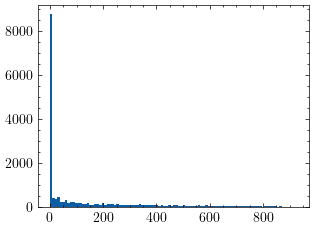

In [63]:
# histogram of irradiance
plt.hist(df['irradiance'], bins=100)
plt.show()

# Capacity estimation based on base load

In [64]:
class capacity_estimation_based_load:
    """
    A class for estimating the capacity of PV systems.
    Step 1: Sample the net load at night time as base load, when irradiance is low and PV gen is zero.
    Step 2: Sample the load around the characteristic dip as noon load, where PV generation is the highest.
    Step 3: Calculate the capacity, which is (base load - noon load) * correction factor,
    where the correction factor is (max_irradiance/sample_irradiance).
    """
    def __init__(self, df: pd.DataFrame, cols: list, irradiance_threshold_noon: float=500, irradiance_threshold_night: float =0.01, max_irradiance: float =1000,base_load_correction_factors =None):
        self.df = df
        self.cols = cols
        self.irradiance_threshold_noon = irradiance_threshold_noon
        self.irradiance_threshold_night= irradiance_threshold_night
        self.max_irradiance = max_irradiance
        self.base_load_correction_factors = base_load_correction_factors
        # why higher threshold_noon?
        # because the when PV gen is dominating, the error is smaller.
        # the minimal irradiance for PV to generate power is 
        self.base_load = None
        self.correction_factors = None
    def estimate_capacity(self) -> pd.Series:
        self.base_load_estimation()
        self.noon_load_estimation()
        # first use base_load - peak_load, then use the correction factor
        pv_gen_not_corrected = self.base_load - self.high_irradiance_df[self.cols] 
        pv_gen_corrected = pv_gen_not_corrected.multiply(self.correction_factors, axis=0)
        pv_gen_capacity= pv_gen_corrected.mean()
        return pv_gen_capacity
    def base_load_estimation(self):
        # use the net load at night time as the base load
        # when irradiance is below threshold, the net load is the base load
        self.base_load_at_night = self.df[self.df['irradiance'] < self.irradiance_threshold_night][self.cols].mean()
        # calculate the correction factor based on total_con(at daylight)/total_con(at night)
        if self.base_load_correction_factors is None:
            self.base_load_correction_factors = self.df[self.df['irradiance'] > self.irradiance_threshold_noon]['total_con'].mean() / self.df[self.df['irradiance'] <= self.irradiance_threshold_night]['total_con'].mean()
        print(f'The base load correction factor is {self.base_load_correction_factors}')
        self.base_load= self.base_load_at_night * self.base_load_correction_factors
        return None
    def noon_load_estimation(self):
        # when irradiance is above threshold, the net load is the noon load
        # add a correction factor here, which is max_irradiance/irradiance
        self.high_irradiance_df = self.df[self.df['irradiance'] > self.irradiance_threshold_noon].copy()
        self.correction_factors = self.max_irradiance / self.high_irradiance_df['irradiance']
        return  None

In [65]:
# deprecated dumb version.
# class capacity_estimation_based_load:
#     """
#     A class for estimating the capacity of a PV system.
#     Step 1: Use the net load at night time as the base load.
#     Step 2: Capture the characteristic dip around solar noon, where PV generation is the highest.
#     Step 3: Calculate the capacity, which is base load - peak load 
#     """
#     def __init__(self, df, cols):
#         self.df = df
#         self.cols = cols
#         self.irradiance_threshold = 800
#         # why higher threshold?
#         # because the when PV gen is dominating, the error is small.
#     def estimate_capacity(self):
#         base_load = self.base_load_estimation()
#         peak_load = self.peak_capture()
#         capacity = base_load - peak_load
#         return capacity
#     def base_load_estimation(self):
#         # use the net load at night time as the base load
#         # when irradiance is below 0.01, the net load is the base load
#         base_load = self.df[self.df['irradiance'] < 0.01][self.cols].mean()
#         return base_load
#     def peak_capture(self):
#         # capture the characteristic dip around solar noon, where PV generation is the highest
#         # when irradiance is above 800, the net load is the peak load
#         # add a correction factor here, which 1000/irradiance
#         high_irradiance_df = self.df[self.df['irradiance'] > self.irradiance_threshold].copy()
#         correction_factors = 1000 / high_irradiance_df['irradiance']
#         corrected_loads = high_irradiance_df[self.cols].multiply(correction_factors, axis=0)
#         peak_load = corrected_loads.mean()
#         return peak_load

In [66]:
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
households_to_remove_with_suffix = [col + '_net' for col in households_to_remove]
net_cols_without_total_net = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]

cap_est_based_load = capacity_estimation_based_load(df,net_cols_without_total_net,base_load_correction_factors=1)
capacity_based_load = cap_est_based_load.estimate_capacity()

The base load correction factor is 1


In [67]:
capacity_based_load

1011W_net    2823.161755
1954W_net    2689.799410
1955A_net    2736.579766
1964J_net    2966.476239
2053G_net    3447.785026
2442E_net    1619.973333
3070L_net    2398.441618
3517V_net     732.923527
3660D_net    2786.203874
3726A_net    3218.803670
3932W_net    1006.592511
4451M_net    5621.090991
5427W_net    1424.390341
5815T_net    2885.878527
7426U_net     764.153599
7679U_net    2404.245831
7710F_net     909.281909
8319Q_net    2827.438312
9248C_net     939.249697
9370J_net    2576.076447
9991J_net    6753.452292
dtype: float64

In [68]:
# the length of capacity_based_load should be the same as df_pv_capacity
len(capacity_based_load)

21

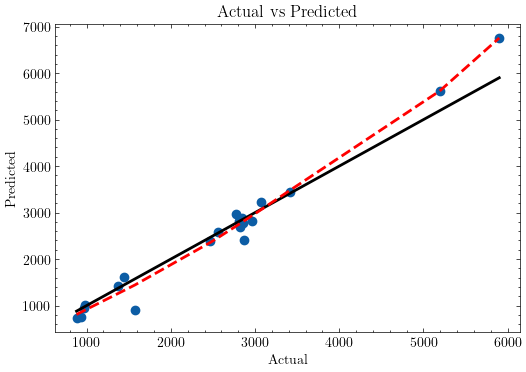

0.9475271825407134

In [69]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
plot_actual_vs_predicted(df_pv_capacity.iloc[:, 1], capacity_based_load)
# calculate the R2 score
r2_score(df_pv_capacity.iloc[:, 1], capacity_based_load)

Except 2108P and 3307S, the capacity of other households are well estimated.\
TODO: check what is wrong with these two.

In [70]:
# print the real capacity and estimated of each household together
for i in range(len(df_pv_capacity)):
    print(f'The real capacity of {df_pv_capacity.iloc[i, 0]} is {df_pv_capacity.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load[i]} W')

The real capacity of 1011W is 2963.038537148181 W, and the estimated capacity is 2823.161754987146 W
The real capacity of 1954W is 2819.0921551825563 W, and the estimated capacity is 2689.799409676182 W
The real capacity of 1955A is 2825.082005695712 W, and the estimated capacity is 2736.57976623251 W
The real capacity of 1964J is 2770.8490332956994 W, and the estimated capacity is 2966.476239396331 W
The real capacity of 2053G is 3409.944231715041 W, and the estimated capacity is 3447.785025716503 W
The real capacity of 2442E is 1446.0585398352928 W, and the estimated capacity is 1619.973332521247 W
The real capacity of 3070L is 2465.613341818588 W, and the estimated capacity is 2398.4416180854932 W
The real capacity of 3517V is 879.8075244566814 W, and the estimated capacity is 732.9235265793908 W
The real capacity of 3660D is 2857.5149109892063 W, and the estimated capacity is 2786.20387358951 W
The real capacity of 3726A is 3065.9703533065262 W, and the estimated capacity is 3218.8

/tmp/ipykernel_811446/4247410128.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The real capacity of {df_pv_capacity.iloc[i, 0]} is {df_pv_capacity.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load[i]} W')


In [71]:
# sum up the capacity of all households both real and estimated
real_capacity = df_pv_capacity['capacity'].sum()
estimated_capacity = capacity_based_load.sum()
print(f'The real capacity is {real_capacity} W, and the estimated capacity is {estimated_capacity} W')
# print the error rate
capacity_error_rate = (real_capacity - estimated_capacity) / real_capacity * 100
print(f'The error rate is {capacity_error_rate}%')
error_factor= real_capacity/estimated_capacity
print(f'The error factor is {error_factor}')

The real capacity is 53504.32336904934 W, and the estimated capacity is 53531.99867354572 W
The error rate is -0.051725361155368625%
The error factor is 0.9994830138014247


In [72]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate.npy", capacity_error_rate)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor.npy", error_factor)

## Sensitivity analysis

In [73]:
# test the irradiance_threshold_noon( ranging 100 to 800,step 100) and irradiance_threshold_night(ranging [0.01,0.1,1,10,50])
def sensitivity_analysis_irradiance_threshold(df_tmp,real_capacity_tmp,fig_name):
    plt.style.use(['science'])
    list_irradiance_thresholds_noon = [10, 20, 30, 40] + list(range(50, 550, 50))
    list_irradiance_thresholds_night = [0.01, 0.1, 1, 10]
    # store the error rates in a matrix
    error_rates = np.zeros((len(list_irradiance_thresholds_noon), len(list_irradiance_thresholds_night)))
    for i, irradiance_threshold_noon in enumerate(list_irradiance_thresholds_noon):
        for j, irradiance_threshold_night in enumerate(list_irradiance_thresholds_night):
            cap_est_based_load = capacity_estimation_based_load(df_tmp,net_cols_without_total_net,irradiance_threshold_noon,irradiance_threshold_night)
            capacity_based_load = cap_est_based_load.estimate_capacity()
            estimated_capacity = capacity_based_load.sum()
            error_rates[i, j] = (real_capacity_tmp - estimated_capacity) / real_capacity_tmp * 100
    # put error_rates, 0, and error_rates.max() in a ascending order list
    v_min_c_max = sorted([error_rates.min(), 0, error_rates.max()])
    # Plot heatmap
    plt.figure(figsize=(6, 4))
    heatmap = plt.imshow(
        error_rates, 
        cmap='RdBu_r', 
        norm=TwoSlopeNorm(vmin=v_min_c_max[0], vcenter=v_min_c_max[1], vmax=v_min_c_max[2]),
        aspect='auto'
    )
    
    # Configure axis labels
    plt.xticks(range(len(list_irradiance_thresholds_night)), list_irradiance_thresholds_night)
    plt.yticks(range(len(list_irradiance_thresholds_noon)), list_irradiance_thresholds_noon)
    plt.xlabel('Irradiance threshold for night time (W/m$^2$)')
    plt.ylabel('Irradiance threshold for noon time (W/m$^2$)')

    # Add colorbar
    ticks = np.linspace(error_rates.min(), error_rates.max(), 6)  # Adjust the number of ticks as needed
    ticks[1:-1] = np.round(ticks[1:-1], -1)  # Round middle ticks to closest multiple of 10
    print(f'The ticks are {ticks}')
    cbar = plt.colorbar(heatmap)
    cbar.set_ticks(ticks)
    cbar.set_label('Error Rate (\%)')

    # # Add title
    # # but not needed for IEEE paper as info are in the caption
    # plt.title('Sensitivity Analysis: Irradiance Threshold')
    # save the figure
    plt.savefig(fig_name, format='pdf')
    # Display plot
    plt.tight_layout()
    plt.show()
    return None

The base load correction factor is 1.0990352730780852
The base load correction factor is 1.0990352730780852
The base load correction factor is 1.0990352730780852
The base load correction factor is 1.073192660959367
The base load correction factor is 1.0900002872241277
The base load correction factor is 1.0900002872241277
The base load correction factor is 1.0900002872241277
The base load correction factor is 1.0643701229136295
The base load correction factor is 1.0832958364305012
The base load correction factor is 1.0832958364305012
The base load correction factor is 1.0832958364305012
The base load correction factor is 1.0578233199458489
The base load correction factor is 1.0771117630636795
The base load correction factor is 1.0771117630636795
The base load correction factor is 1.0771117630636795
The base load correction factor is 1.0517846582989667
The base load correction factor is 1.0656998884472562
The base load correction factor is 1.0656998884472562
The base load correction fact

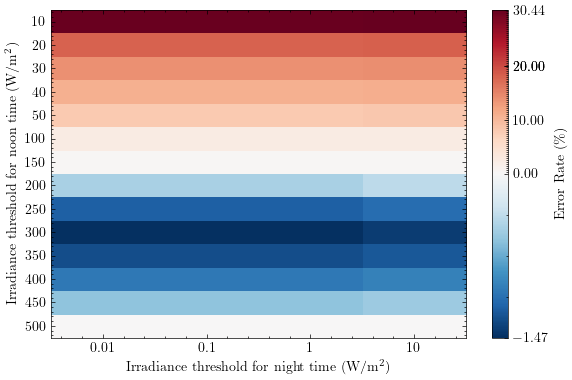

In [74]:
sensitivity_analysis_irradiance_threshold(df,real_capacity,fig_name='../figs/sensitivity_analysis_irradiance_threshold.pdf')

## Check 3307S

In [75]:
# # plot the net load, pv gen and consumption of 3307S, during 2018-07-01 to 2018-07-04
# df_common_xylabel_plot(df[(df['doy'] >= 182) & (df['doy'] <=  185) & (df['year'] == 2018)],y=['3307S_net','3307S_pv','3307S_con'],ylabel='Load (W)',layout=(3,1))

In [76]:
# # plot the net load, pv gen and consumption of 3307S, during 2018-09-01 to 2018-09-04
# df_common_xylabel_plot(df[(df['doy'] >= 244) & (df['doy'] <=  247) & (df['year'] == 2018)],y=['3307S_net','3307S_pv','3307S_con'],ylabel='Load (W)',layout=(3,1))

It seems that household 3307S is using some demand response strategies.
Let's check a normal household 2053G

In [77]:
# # plot the net load, pv gen and consumption of 2053G, during 2022-07-01 to 2022-07-4
# df_common_xylabel_plot(df[(df['doy'] >= 182) & (df['doy'] <=  185) & (df['year'] == 2018)],y=['2053G_net','2053G_pv','2053G_con'],ylabel='Load (W)',layout=(3,1))

## Check 2108P

In [78]:
# # plot the net load, pv gen and consumption of 2108P, during 2018-07-01 to 2018-07-04
# df_common_xylabel_plot(df[(df['doy'] >= 182) & (df['doy'] <=  185) & (df['year'] == 2018)],y=['2108P_net','2108P_pv','2108P_con'],ylabel='Load (W)',layout=(3,1))


In [79]:
# # plot the net load, pv gen and consumption of 2108P, for all days in 2018
# df_common_xylabel_plot(df[(df['year'] == 2018)],y=['2108P_net','2108P_pv','2108P_con'],ylabel='Load (W)',layout=(3,1))


In [80]:
# # plot the net load, pv gen and consumption of 2108P, during 2018-07-19 to 2018-07-25
# df_common_xylabel_plot(df[(df['doy'] >= 200) & (df['doy'] <=  206) & (df['year'] == 2018)],y=['2108P_net','2108P_pv','2108P_con'],ylabel='Load (W)',layout=(3,1))

# base_load_correction_factors for two parts

In [81]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part1 if col != 'total_net']
cap_est_based_load_part1_tmp = capacity_estimation_based_load(df_part1,net_cols_without_total_net)
base_load_correction_factors_from_part1=cap_est_based_load_part1_tmp.base_load_correction_factors
base_load_correction_factors_from_part1

In [82]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part2 if col != 'total_net']
cap_est_based_load_part2_tmp = capacity_estimation_based_load(df_part2,net_cols_without_total_net)
base_load_correction_factors_from_part2=cap_est_based_load_part2_tmp.base_load_correction_factors
base_load_correction_factors_from_part2

# Estimation for part 1

In [83]:
# columns that ends with '_net'
net_cols = [col for col in df_part1.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part1 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part1 if col != 'total_net']

cap_est_based_load_part1 = capacity_estimation_based_load(df_part1,net_cols_without_total_net,base_load_correction_factors=base_load_correction_factors_from_part2)
# cap_est_based_load_part1 = capacity_estimation_based_load(df_part1,net_cols_without_total_net,base_load_correction_factors=1)
capacity_based_load_part1 = cap_est_based_load_part1.estimate_capacity()
capacity_based_load_part1

The base load correction factor is 0.9561669848453539


1011W_net    2805.024812
1954W_net    2666.263362
1955A_net    2715.463737
1964J_net    2928.759177
2053G_net    3421.384418
2442E_net    1588.326568
3070L_net    2380.594661
3517V_net     713.960880
3660D_net    2767.637727
3726A_net    3194.637009
dtype: float64

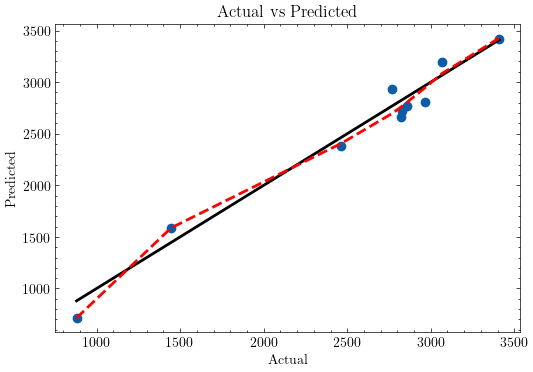

0.9699049608846599

In [84]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
# TODO: add the name of the households to the figure, so each dot has a label
plot_actual_vs_predicted(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1,fig_name='../figs/actual_vs_predicted_capacity_part1.pdf')
# calculate the R2 score
r2_score(df_pv_capacity_part1.iloc[:, 1], capacity_based_load_part1)

In [85]:
# print the real capacity and estimated of each household together
for i in range(len(df_pv_capacity_part1)):
    print(f'The real capacity of {df_pv_capacity_part1.iloc[i, 0]} is {df_pv_capacity_part1.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part1[i]} W')

The real capacity of 1011W is 2963.038537148181 W, and the estimated capacity is 2805.0248124342465 W
The real capacity of 1954W is 2819.0921551825563 W, and the estimated capacity is 2666.2633618609034 W
The real capacity of 1955A is 2825.082005695712 W, and the estimated capacity is 2715.4637368714043 W
The real capacity of 1964J is 2770.8490332956994 W, and the estimated capacity is 2928.759177172368 W
The real capacity of 2053G is 3409.944231715041 W, and the estimated capacity is 3421.3844177440633 W
The real capacity of 2442E is 1446.0585398352928 W, and the estimated capacity is 1588.3265677265244 W
The real capacity of 3070L is 2465.613341818588 W, and the estimated capacity is 2380.5946612623043 W
The real capacity of 3517V is 879.8075244566814 W, and the estimated capacity is 713.9608799253043 W
The real capacity of 3660D is 2857.5149109892063 W, and the estimated capacity is 2767.6377266403283 W
The real capacity of 3726A is 3065.9703533065262 W, and the estimated capacity i

/tmp/ipykernel_811446/2473863109.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The real capacity of {df_pv_capacity_part1.iloc[i, 0]} is {df_pv_capacity_part1.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part1[i]} W')


In [86]:
# sum up the capacity of all households both real and estimated
real_capacity_part1 = df_pv_capacity_part1['capacity'].sum()
estimated_capacity_part1 = capacity_based_load_part1.sum()
print(f'The real capacity is {real_capacity_part1} W, and the estimated capacity is {estimated_capacity_part1} W')
# print the error rate
capacity_error_rate_part1 = (real_capacity_part1 - estimated_capacity_part1) / real_capacity_part1 * 100
print(f'The error rate is {capacity_error_rate_part1}%')
error_factor_part1= real_capacity_part1/estimated_capacity_part1
print(f'The error factor is {error_factor_part1}')

The real capacity is 25502.97063344348 W, and the estimated capacity is 25182.05235074581 W
The error rate is 1.25835647662486%
The error factor is 1.0127439288199307


In [87]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate_part1.npy", capacity_error_rate_part1)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor_part1.npy", error_factor_part1)

The base load correction factor is 1.0953067693873388
The base load correction factor is 1.0953067693873388
The base load correction factor is 1.0953067693873388
The base load correction factor is 1.0684803303180912
The base load correction factor is 1.0847360681880944
The base load correction factor is 1.0847360681880944
The base load correction factor is 1.0847360681880944
The base load correction factor is 1.058168528524535
The base load correction factor is 1.076541846047722
The base load correction factor is 1.076541846047722
The base load correction factor is 1.076541846047722
The base load correction factor is 1.0501750006618868
The base load correction factor is 1.0684464030907483
The base load correction factor is 1.0684464030907483
The base load correction factor is 1.0684464030907483
The base load correction factor is 1.0422778326661328
The base load correction factor is 1.0565763086851134
The base load correction factor is 1.0565763086851134
The base load correction factor 

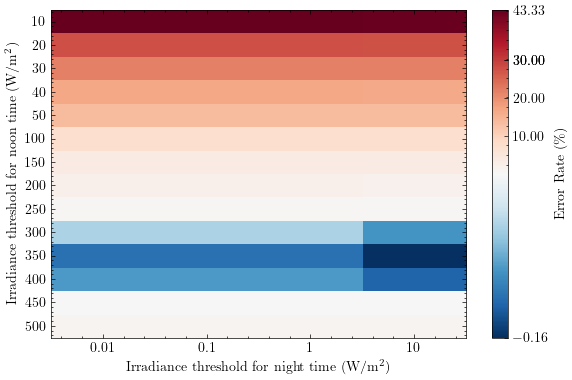

In [88]:
sensitivity_analysis_irradiance_threshold(df_part1,real_capacity_part1,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part1.pdf')

# Estimation for part 2

In [89]:
# columns that ends with '_net'
net_cols = [col for col in df_part2.columns if col.endswith('_net')]
# create an instance of capacity_estimation_based_load
# remove total_net and households to remove from net_cols
net_cols_part2 = [col for col in net_cols if col != 'total_net' and col not in households_to_remove_with_suffix]
net_cols_without_total_net = [col for col in net_cols_part2 if col != 'total_net']

cap_est_based_load_part2 = capacity_estimation_based_load(df_part2,net_cols_without_total_net,base_load_correction_factors=base_load_correction_factors_from_part1)
# cap_est_based_load_part2 = capacity_estimation_based_load(df_part2,net_cols_without_total_net,base_load_correction_factors=1)
capacity_based_load_part2 = cap_est_based_load_part2.estimate_capacity()
capacity_based_load_part2

The base load correction factor is 1.0233585991896819


3932W_net    1010.096263
4451M_net    5649.466423
5427W_net    1428.810348
5815T_net    2898.607869
7426U_net     777.971878
7679U_net    2413.085247
7710F_net     926.463150
8319Q_net    2837.749945
9248C_net     945.693070
9370J_net    2583.070367
9991J_net    6788.662481
dtype: float64

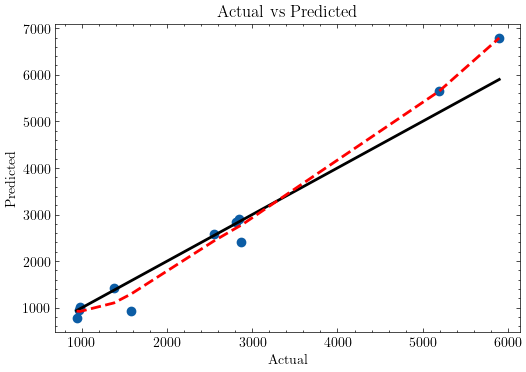

0.9414413391707912

In [90]:
# plot the estimated capacity vs the actual capacity
# the second column of df_pv_capacity is the actual capacity
# TODO: add the name of the households to the figure, so each dot has a label
plot_actual_vs_predicted(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2,fig_name='../figs/actual_vs_predicted_capacity_part2.pdf')
# calculate the R2 score
r2_score(df_pv_capacity_part2.iloc[:, 1], capacity_based_load_part2)

In [91]:
# print the real capacity and estimated of each household together
for i in range(len(df_pv_capacity_part2)):
    print(f'The real capacity of {df_pv_capacity_part2.iloc[i, 0]} is {df_pv_capacity_part2.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part2[i]} W')

The real capacity of 3932W is 981.1300646774204 W, and the estimated capacity is 1010.096263140177 W
The real capacity of 4451M is 5192.548449412307 W, and the estimated capacity is 5649.466423459548 W
The real capacity of 5427W is 1374.0352311787085 W, and the estimated capacity is 1428.8103475108503 W
The real capacity of 5815T is 2848.621676525069 W, and the estimated capacity is 2898.607868672982 W
The real capacity of 7426U is 934.9368539705436 W, and the estimated capacity is 777.9718779392581 W
The real capacity of 7679U is 2871.8978370916 W, and the estimated capacity is 2413.08524682239 W
The real capacity of 7710F is 1574.4987158879314 W, and the estimated capacity is 926.4631499838052 W
The real capacity of 8319Q is 2803.4673875296758 W, and the estimated capacity is 2837.749944770897 W
The real capacity of 9248C is 965.2160832358916 W, and the estimated capacity is 945.693069967606 W
The real capacity of 9370J is 2554.7716128546763 W, and the estimated capacity is 2583.0703

/tmp/ipykernel_811446/949596013.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The real capacity of {df_pv_capacity_part2.iloc[i, 0]} is {df_pv_capacity_part2.iloc[i, 1]} W, and the estimated capacity is {capacity_based_load_part2[i]} W')


In [92]:
# sum up the capacity of all households both real and estimated
real_capacity_part2 = df_pv_capacity_part2['capacity'].sum()
estimated_capacity_part2 = capacity_based_load_part2.sum()
print(f'The real capacity is {real_capacity_part2} W, and the estimated capacity is {estimated_capacity_part2} W')
# print the error rate
capacity_error_rate_part2 = (real_capacity_part2 - estimated_capacity_part2) / real_capacity_part2 * 100
print(f'The error rate is {capacity_error_rate_part2}%')
error_factor_part2= real_capacity_part2/estimated_capacity_part2
print(f'The error factor is {error_factor_part2}')

The real capacity is 28001.352735605855 W, and the estimated capacity is 28259.677040443763 W
The error rate is -0.9225422331451476%
The error factor is 0.9908589081018793


In [93]:
# save the error rate to a npy file
np.save("../data/nl/capacity_error_rate_part2.npy", capacity_error_rate_part2)
# save the error factor to a npy file
np.save("../data/nl/capacity_error_factor_part2.npy", error_factor_part2)

The base load correction factor is 1.1026699930158708
The base load correction factor is 1.1026699930158708
The base load correction factor is 1.1026699930158708
The base load correction factor is 1.0777955680459326
The base load correction factor is 1.0951320943709537
The base load correction factor is 1.0951320943709537
The base load correction factor is 1.0951320943709537
The base load correction factor is 1.0704277120207129
The base load correction factor is 1.089879942425844
The base load correction factor is 1.089879942425844
The base load correction factor is 1.089879942425844
The base load correction factor is 1.0652940400018882
The base load correction factor is 1.0855591616112177
The base load correction factor is 1.0855591616112177
The base load correction factor is 1.0855591616112177
The base load correction factor is 1.0610707289097225
The base load correction factor is 1.074593981095666
The base load correction factor is 1.074593981095666
The base load correction factor i

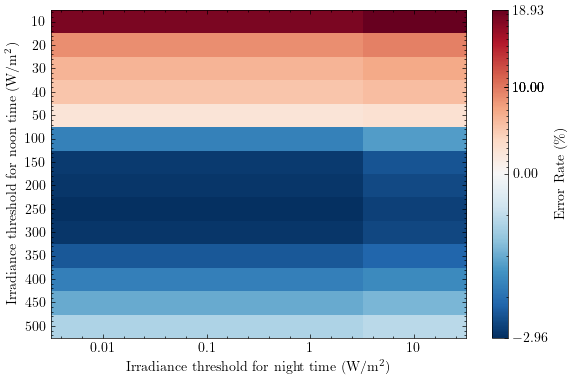

In [94]:
sensitivity_analysis_irradiance_threshold(df_part2,real_capacity_part2,fig_name='../figs/sensitivity_analysis_irradiance_threshold_part2.pdf')